In [2]:
import torch
import matplotlib.pyplot as plt
#from datasets import concatenate_datasets

import sys
sys.path.append('./src')

from data import load_data, get_data_sl
from visualize import plot_outcome_distribution, visualize_examples
from model import get_model
from causal import compute_ead
from train import train_model

/nfs/scistore19/locatgrp/rcadei/ISTAnt/crl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [3]:
supervised = load_data(environment='supervised')
unsupervised = load_data(environment='unsupervised')

### Sanity Check

In [3]:
encoder_name = "vit"
processor, model = get_model(encoder_name)

Top 5 predicted labels with associated probabilities:
    1. Petri dish: 98.90%
    2. tick: 0.26%
    3. nematode, nematode worm, roundworm: 0.18%
    4. ant, emmet, pismire: 0.13%
    5. beaker: 0.06%


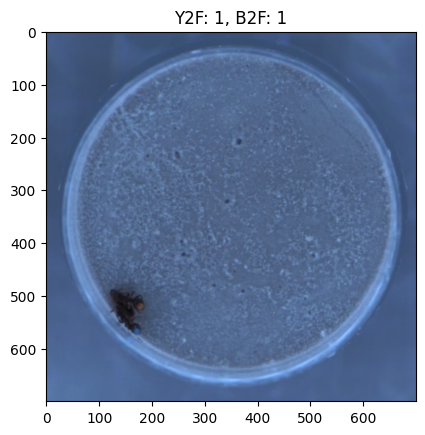

In [4]:
idx = 15000
img = supervised[idx]['image']
outcome = supervised[idx]['outcome']
inputs = processor(images=img, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
print("Top 5 predicted labels with associated probabilities:")
top_5 = torch.topk(logits, 5)
probs = logits.softmax(-1)[0][top_5.indices][0]
for i, (idx, prob) in enumerate(zip(top_5.indices[0], probs), 1):
    print(f"    {i}. {model.config.id2label[idx.item()]}: {prob.item():.2%}")

img = img.permute(1, 2, 0)
plt.title(f"Y2F: {int(outcome[0])}, B2F: {int(outcome[1])}")
plt.imshow(img);

In [5]:
inputs = processor(images=img, return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)
outputs.hidden_states[-1][:,0].shape
# outputs.hidden_states[-1].mean(dim=[2,3]).shape

torch.Size([1, 768])

## Supervised Learning

In [4]:
X, y, split = get_data_sl(environment="supervised", 
                          encoder_name="dino",
                          task="or", 
                          split_criteria="experiment_easy", 
                          token="mean")

In [10]:
model = train_model(X, y,  
                    split=split,
                    batch_size=256, 
                    num_epochs=10, 
                    lr=0.01, 
                    verbose=True)
y_probs = model.probs(X.to(model.device)).to("cpu")
y_pred = model.pred(X.to(model.device)).to("cpu")

Device: cpu
Starting perfomances
  train:  Accuracy=0.755, Precision=nan, Recall=0.000
  val:  Accuracy=0.752, Precision=nan, Recall=0.000
Epoch 0


100%|██████████| 493/493 [00:03<00:00, 127.15it/s]


  Train: Loss=0.609
  train:  Accuracy=0.867, Precision=0.825, Recall=0.578
  val:  Accuracy=0.815, Precision=0.676, Recall=0.490
Epoch 1


100%|██████████| 493/493 [00:04<00:00, 101.33it/s]


  Train: Loss=0.282
  train:  Accuracy=0.897, Precision=0.801, Recall=0.774
  val:  Accuracy=0.801, Precision=0.618, Recall=0.519
Epoch 2


100%|██████████| 493/493 [00:05<00:00, 98.08it/s] 


  Train: Loss=0.242
  train:  Accuracy=0.809, Precision=0.563, Recall=0.982
  val:  Accuracy=0.723, Precision=0.467, Recall=0.849
Epoch 3


100%|██████████| 493/493 [00:05<00:00, 96.76it/s] 


  Train: Loss=0.221
  train:  Accuracy=0.923, Precision=0.835, Recall=0.855
  val:  Accuracy=0.804, Precision=0.596, Recall=0.649
Epoch 4


100%|██████████| 493/493 [00:04<00:00, 100.12it/s]


  Train: Loss=0.201
  train:  Accuracy=0.925, Precision=0.824, Recall=0.883
  val:  Accuracy=0.781, Precision=0.551, Recall=0.625
Epoch 5


100%|██████████| 493/493 [00:05<00:00, 93.14it/s] 


  Train: Loss=0.188
  train:  Accuracy=0.928, Precision=0.820, Recall=0.907
  val:  Accuracy=0.744, Precision=0.489, Recall=0.716
Epoch 6


100%|██████████| 493/493 [00:05<00:00, 96.85it/s] 


  Train: Loss=0.175
  train:  Accuracy=0.929, Precision=0.805, Recall=0.937
  val:  Accuracy=0.764, Precision=0.517, Recall=0.690
Epoch 7


100%|██████████| 493/493 [00:05<00:00, 97.99it/s] 


  Train: Loss=0.173
  train:  Accuracy=0.919, Precision=0.781, Recall=0.931
  val:  Accuracy=0.743, Precision=0.487, Recall=0.695
Epoch 8


100%|██████████| 493/493 [00:05<00:00, 92.21it/s] 


  Train: Loss=0.165
  train:  Accuracy=0.940, Precision=0.855, Recall=0.908
  val:  Accuracy=0.776, Precision=0.539, Recall=0.668
Epoch 9


100%|██████████| 493/493 [00:05<00:00, 93.21it/s]


  Train: Loss=0.163
  train:  Accuracy=0.942, Precision=0.859, Recall=0.913
  val:  Accuracy=0.733, Precision=0.472, Recall=0.638


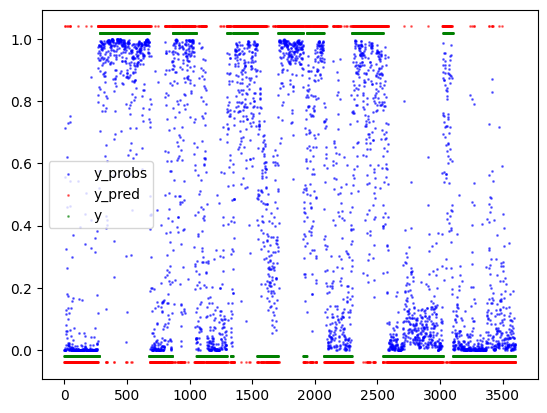

In [29]:
exp_a = (supervised["experiment"]==1)
pos_1 = (supervised["position"]==2)
filter = (exp_a & pos_1).nonzero().squeeze()
y_probs[filter].detach()

plt.scatter(range(len(filter)), y_probs[filter].detach(), s=1, c="blue", alpha=0.5, label="y_probs")
plt.scatter(range(len(filter)), y_pred[filter].detach()-(-1)**y_pred[filter].detach()*0.04, s=1, c="red", alpha=0.5, label="y_pred")
plt.scatter(range(len(filter)), y[filter].detach()-(-1)**y[filter].detach()*0.02, s=1, c="green", alpha=0.5, label="y")
plt.legend()
plt.show()

In [ ]:
visualize_examples(n=36, 
                   task="all", 
                   encoder_name="dino", 
                   model=model, 
                   save=True, 
                   data_dir="./data",
                   results_dir="./results")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

outcome_idx = 0

model = LogisticRegression(solver='liblinear', max_iter=10) 
model.fit(X_train, y_train[:,outcome_idx])

y_train_pred = model.predict(X_train)  
y_val_pred = model.predict(X_val)  
print(classification_report(y_train[:,outcome_idx], y_train_pred))
print(classification_report(y_val[:,outcome_idx], y_val_pred))

In [ ]:
import svmutil  
from sklearn.metrics import classification_report

outcome_idx = 0

prob = svmutil.svm_problem(y[:, otcome_idx], X)
param = svmutil.svm_parameter('-s 0 -t 2 -c 1 -g 0.1')  
model = svmutil.svm_train(prob, param) 

y_pred = model.predict(X)  
print(classification_report(y[:,outcome_idx], y_pred))

In [ ]:
import matplotlib.pyplot as plt

id_1s = (torch.Tensor(y_pred) == 1).nonzero(as_tuple=True)[0]#[0]
id_1 = id_1s[0].item()

train = load_data(environment='train')
example = train[id_1]["image"]

img = example.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()

## Causal Inference

In [ ]:
plot_outcome_distribution(train, save=True)

In [ ]:
rct = train #concatenate_datasets([train, test])
Y = rct["outcome"]
T = rct["treatment"]

EAD_B_y, EAD_inf_y = compute_ead(Y, T, color="Yellow")   
EAD_B_b, EAD_inf_b = compute_ead(Y, T, color="Blue")   